# IMPORTING LIBRARY

In [1]:
import pandas as pd
import neurokit2 as nk
from warnings import warn
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

from neurokit2.misc import NeuroKitWarning, as_vector
from neurokit2.signal import signal_filter, signal_smooth
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

# DATA LOADING

In [5]:
eda_signal = pd.read_csv("C:/Users/AmitDebnath/Downloads/Kaggle dataset and ground truth/p1.csv/p1_18547_rows_value.csv")

# PLOT RAW DATA

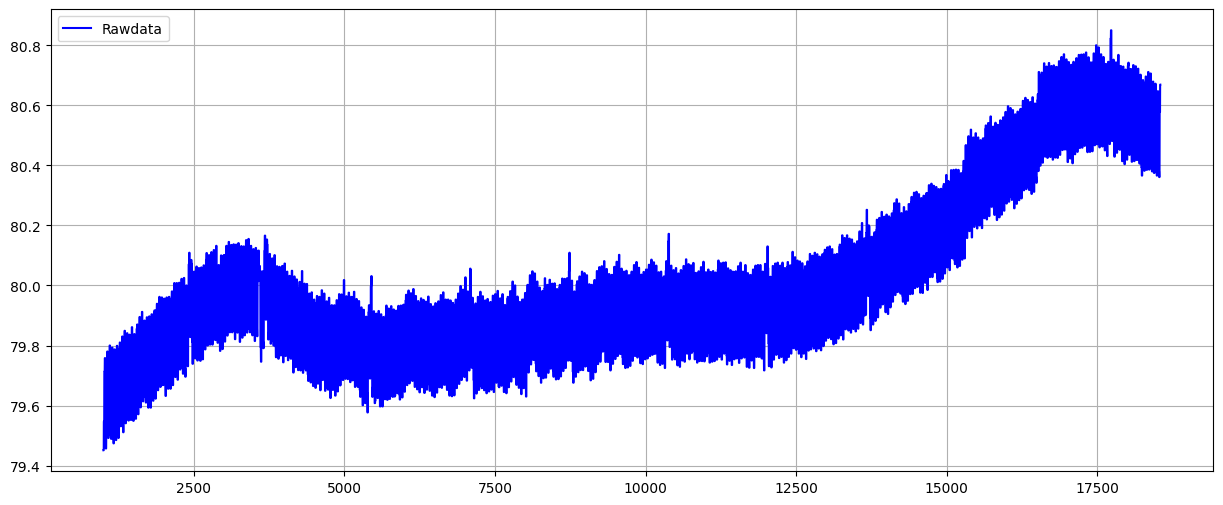

In [6]:
# 6. Plot signals based on their their respective time axes
eda_signal2 = eda_signal[1000:]
plt.figure(figsize=(15, 6))
plt.plot(eda_signal2, label='Rawdata', color='blue')

plt.legend()
plt.grid(True)
plt.show()

# MAIN eda_clean FUNCTION

In [7]:
def eda_clean(eda_signal2, sampling_rate=128, method="neurokit"):
    eda_signal2 = as_vector(eda_signal2)
    
    # Missing data
    n_missing = np.sum(np.isnan(eda_signal2))
    if n_missing > 0:
        warn(
            "there are" + str(n_missing) + "missing data points in your signal."
            "Filling missing values by using the forward filling method.",
            category=NeuroKitWarning,
        )
        eda_signal2 = _eda_clean_missing(eda_signal2)
        
    method = method.lower()   # Remove capital letters
    if method == "biosppy":
        clean = _eda_clean_biosppy(eda_signal2, sampling_rate)
    elif method in ["dafault", "neurokit", "nk"]:
        clean = _eda_clean_neurokit(eda_signal2, sampling_rate)
    elif method is None or method == "none":
        clean = eda_signal2
    else:
        raise ValueError("NeuroKit error: eda_clean():'method' should be one of the 'NeuroKit' or 'None'.")
    
    return clean

# HANDLE MISSING DATA

In [8]:
def _eda_clean_missing(eda_signal2):
    
    eda_signal1 = pd.DataFrame.pad(pd.Series(eda_signal2))
    
    return eda_signal2

# NEUROKIT LIBRARY PARAMETRIC FUNCTION

In [9]:
def _eda_clean_neurokit(eda_signal2, sampling_rate=128):
    
    if sampling_rate <= 6:
        warn(
            "EDA signal is sampled at very low frequency. Skipping filtering.",
            category=NeuroKitWarning,
        )
        return eda_signal2
    
    # Filtering
    filtered = signal_filter(
        eda_signal2, sampling_rate=sampling_rate, highcut=3, method="butterworth", order=4
    )
    return filtered

# RETURNS CLEAN DATA

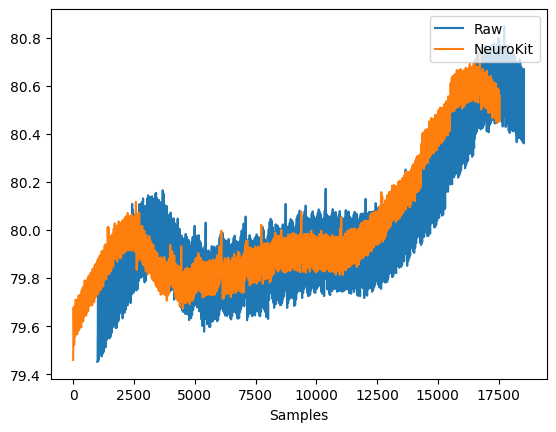

In [10]:
# Clean
eda_cleaned = eda_clean(eda_signal2, sampling_rate=128, method='neurokit')

nk.signal_plot([eda_signal2, eda_cleaned], labels=["Raw", "NeuroKit"])


# BioSPPy ALGO

In [11]:
# from scipy.stats import pearsonr

def _eda_clean_biosppy(eda_signal2, sampling_rate=128):
    
    # Parameters
    order = 4
    frequency = 5
    frequency = (
        2 * np.array(frequency) / sampling_rate
    ) # Normalize frequency to Nyquist Frequency (Fs/2)
    
    # Filtering
    b,a = scipy.signal.butter(N=order, Wn=frequency, btype="lowpass", analog=False, output="ba")
    filtered = scipy.signal.filtfilt(b, a, eda_signal2)
    
    # Smoothing
    clean = signal_smooth(
        filtered, method="convolution", kernel="boxcar", size=int(0.05 * sampling_rate)
    )
    
    return clean


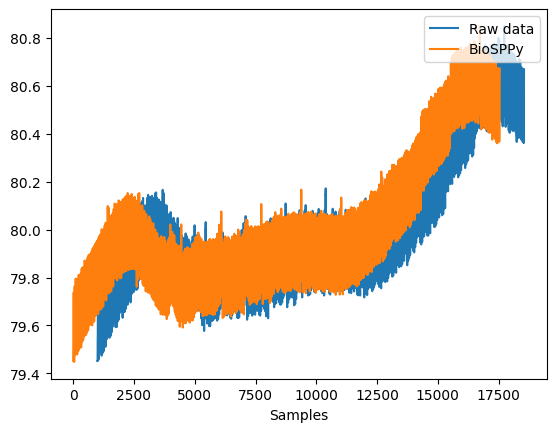

In [12]:
# Clean
eda_clean2 = eda_clean(eda_signal2, sampling_rate=128, method='biosppy')

nk.signal_plot([eda_signal2, eda_clean2], labels=[ "Raw data", "BioSPPy"])

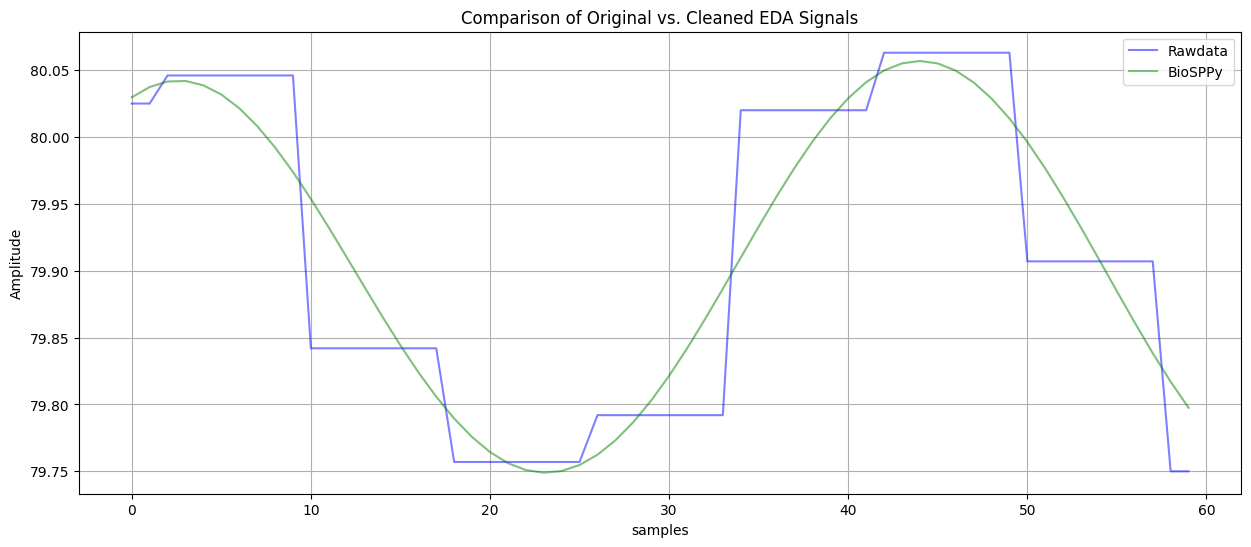

In [13]:
# 6. Plot BOTH signals against their respective time axes
plt.figure(figsize=(15, 6))
# plt.plot(np.arange(200),eda_signal2[3000:3200], label='Raw data', color='red', alpha=0.8)
# plt.plot(np.arange(200),eda_clean2[3000:3200], label='BioSPPy', color='black', alpha=0.7)
plt.plot(np.arange(60), eda_signal2[1500:1560], label="Rawdata", color='blue', alpha=0.5)
plt.plot(np.arange(60),eda_clean2[1500:1560], label="BioSPPy", color='green', alpha=0.5)


plt.title('Comparison of Original vs. Cleaned EDA Signals')
plt.xlabel('samples')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
print(mean_squared_error(eda_signal2,eda_clean2))

0.0023626736171414716


In [15]:
print(pearsonr(eda_signal2.iloc[:, 0], eda_clean2)[0])

0.9861639934293378
